In [1]:
from pathlib import Path
from anndata import read_h5ad

import sys
import scanpy as sc
import os
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import nbinom, pearsonr

from tqdm import tqdm

import pickle
import anndata as ad
from scipy.stats import zscore
from PIL import Image
from stimage._utils import gene_plot

In [2]:
from scipy import stats

def plot_correlation(df, attr_1, attr_2):
    r = stats.pearsonr(df[attr_1], 
                       df[attr_2])[0] **2

    g = sns.lmplot(data=df,
        x=attr_1, y=attr_2,
        height=5, legend=True
    )
    # g.set(ylim=(0, 360), xlim=(0,360))

    g.set_axis_labels(attr_1, attr_2)
    plt.annotate(r'$R^2:{0:.2f}$'.format(r),
                (max(df[attr_1])*0.9, max(df[attr_2])*0.9))
    return g


def calculate_correlation(attr_1, attr_2):
    r = stats.pearsonr(attr_1, 
                       attr_2)[0]
    return r

def calculate_correlation_2(attr_1, attr_2):
    r = stats.spearmanr(attr_1, 
                       attr_2)[0]
    return r

In [3]:
PATH_PRED = Path("/scratch/project_mnt/S0010/Xiao/Q1851/Xiao/Wiener_backup/STimage_exp/Breast_9visium_299")
# PATH_GC = Path("/scratch/imb/uqjxie6/benchmmarking/DeepHis2Exp/data/SkinVisium")
OUT_PATH = PATH_PRED / "PLOT"
OUT_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
adata_dict = {}
for file_path in PATH_PRED.glob("./*A.h5ad"):
    library_id = file_path.stem.split("_")[-1]
    adata = ad.read_h5ad(file_path)
    adata_dict[library_id] = adata

In [5]:
adata_dict

{'5626A': AnnData object with n_obs × n_vars = 1655 × 1522
     obs: 'array_row', 'array_col', 'imagerow', 'imagecol', 'library_id', 'tile_tissue_mask_path', 'tissue_area', 'tile_path'
     uns: 'spatial'
     obsm: 'predicted_gene', 'spatial',
 '1302A': AnnData object with n_obs × n_vars = 1614 × 1522
     obs: 'array_row', 'array_col', 'imagerow', 'imagecol', 'library_id', 'tile_tissue_mask_path', 'tissue_area', 'tile_path'
     uns: 'spatial'
     obsm: 'predicted_gene', 'spatial',
 '1480A': AnnData object with n_obs × n_vars = 1436 × 1522
     obs: 'array_row', 'array_col', 'imagerow', 'imagecol', 'library_id', 'tile_tissue_mask_path', 'tissue_area', 'tile_path'
     uns: 'spatial'
     obsm: 'predicted_gene', 'spatial',
 '1956A': AnnData object with n_obs × n_vars = 750 × 1522
     obs: 'array_row', 'array_col', 'imagerow', 'imagecol', 'library_id', 'tile_tissue_mask_path', 'tissue_area', 'tile_path'
     uns: 'spatial'
     obsm: 'predicted_gene', 'spatial',
 '5165A': AnnData obj

In [6]:
with open(PATH_PRED / "xenium_gene_list.pkl", "rb") as f:
    gene_list_xenium = pickle.load(f)

In [7]:
common_genes = list(set(gene_list_xenium) & set(adata_dict["2556A"].var_names))
len(common_genes)

162

In [ ]:
gene_to_plot = ["CD163", "ESR1", "MS4A1", "BRCA2", "TP53", "ERBB2"]
for library_id, adata in adata_dict.items():
    adata = adata[:, common_genes]
    adata.uns['spatial'][library_id]['scalefactors'] = {'tissue_hires_scalef': 0.1}
    hires = Image.fromarray(adata.uns["spatial"][library_id]["images"]["fulres"])
    hires.thumbnail((hires.size[0]//10, hires.size[1]//10))
    adata.uns["spatial"][library_id]["images"]["hires"] = hires
    adata.X = adata.to_df().apply(zscore)
    for gene in gene_to_plot:
        gene_plot(adata, genes=gene, image_scale=True, library_id=library_id, spot_size=30,
                        output=str(OUT_PATH), name=f"pred_{library_id}_{gene}.pdf")
        plt.close()


In [ ]:
# from stimage2.datasets.Xenium_dataset import Blake_xenium, Pfizer_xenium
# from pathlib import Path
# import pickle
# gene_list = []
# for i in range(len(sdataset)):
#     sdata = sdataset.load_data(i)
#     gene_list.append(sdata["table"].var_names.values.tolist())
# gene_list = list(set([item for items in gene_list for item in items]))
# with open(PATH_PRED / "xenium_gene_list.pkl", "wb") as f:
#     pickle.dump(gene_list, f)

In [ ]:
import stlearn as st
from pathlib import Path
import matplotlib.pyplot as plt
from pyometiff import OMETIFFReader
gene_to_plot = ["CD163", "ESR1", "MS4A1", "BRCA2", "TP53", "ERBB2"]
for external_data_path in Path("/scratch/project_mnt/S0010/Xiao/Q1851/Xiao/Xenium_dataset/BreastCancer/Pfizer/").glob("./*A"):
    print(external_data_path)
    library_id = external_data_path.stem
    adata = st.ReadXenium(feature_cell_matrix_file=external_data_path / "cell_feature_matrix.h5",
                     cell_summary_file=external_data_path / "cells.csv.gz",
                     library_id=library_id,
                     scale=1,
                     spot_diameter_fullres=15 # Recommend
                     )
    n_ =70
    grid = st.tl.cci.grid(adata, n_row=n_, n_col=n_)
    for gene in gene_to_plot:
        fig, ax = plt.subplots()
        st.pl.gene_plot(grid,gene_symbols=gene, ax=ax, show_plot=False)
        fig.savefig(OUT_PATH / f"gt_{library_id}_{gene}.pdf")
        break
        plt.close()
    break

INFO     reading                                                                                                   
         /scratch/project_mnt/S0010/Xiao/Q1851/Xiao/Xenium_dataset/BreastCancer/Pfizer/2556A/cell_feature_matrix.h5
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


/home/uqxtan9/micromamba/envs/stimage2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[3.64238051e-02 0.00000000e+00 6.90611431e+01]                                                    
          [0.00000000e+00 3.64243446e-02 7.03713544e+00]                                                           
          [0.00000000e+00 0.00000000e+00 1.00000000e+00]]                                                          
         eigenvalues=[0.03642381 0.03642434]                                                                       
         scale_factor=0.0364240748178192                                                                           
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

/home/uqxtan9/micromamba/envs/stimage2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[0.04394349 0.         0.        ]                                                                
          [0.         0.04395029 0.        ]                                                                       
          [0.         0.         1.        ]]                                                                      
         eigenvalues=[0.04394349 0.04395029]                                                                       
         scale_factor=0.043946890417584025                                                                         
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

/home/uqxtan9/micromamba/envs/stimage2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[0.04196416 0.         0.        ]                                                                
          [0.         0.04196215 0.        ]                                                                       
          [0.         0.         1.        ]]                                                                      
         eigenvalues=[0.04196416 0.04196215]                                                                       
         scale_factor=0.041963155428679434                                                                         
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

/home/uqxtan9/micromamba/envs/stimage2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[0.03691132 0.         0.        ]                                                                
          [0.         0.03690718 0.        ]                                                                       
          [0.         0.         1.        ]]                                                                      
         eigenvalues=[0.03691132 0.03690718]                                                                       
         scale_factor=0.036909249088105056                                                                         
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

/home/uqxtan9/micromamba/envs/stimage2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[ 0.04101858  0.          0.        ]                                                             
          [ 0.          0.04101087 23.97363284]                                                                    
          [ 0.          0.          1.        ]]                                                                   
         eigenvalues=[0.04101858 0.04101087]                                                                       
         scale_factor=0.041014724221149435                                                                         
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

/home/uqxtan9/micromamba/envs/stimage2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[0.03683066 0.         2.5101572 ]                                                                
          [0.         0.03682834 0.        ]                                                                       
          [0.         0.         1.        ]]                                                                      
         eigenvalues=[0.03683066 0.03682834]                                                                       
         scale_factor=0.036829502246734744                                                                         
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

/home/uqxtan9/micromamba/envs/stimage2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[0.03675439 0.         0.        ]                                                                
          [0.         0.03674242 0.        ]                                                                       
          [0.         0.         1.        ]]                                                                      
         eigenvalues=[0.03675439 0.03674242]                                                                       
         scale_factor=0.036748402961862034                                                                         
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

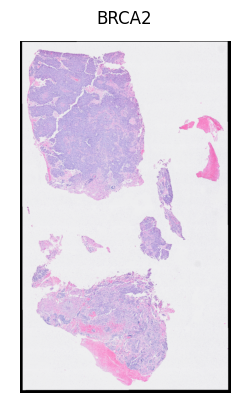

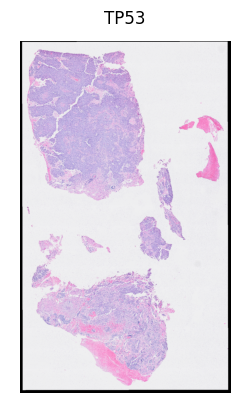

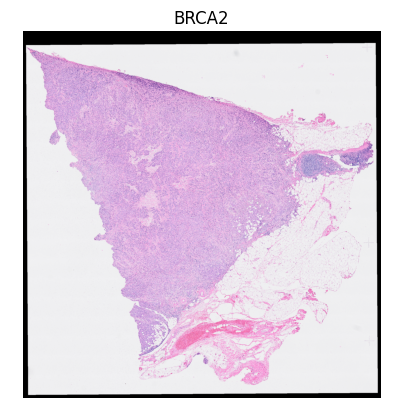

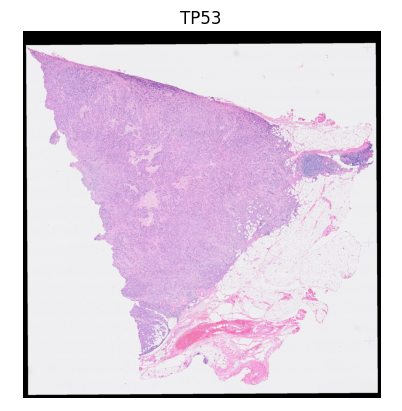

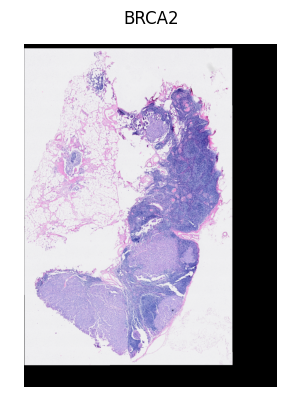

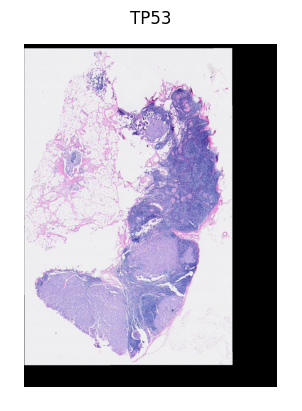

In [28]:
from stimage2.datasets.Xenium_dataset import Pfizer_xenium
from pathlib import Path
import pickle
from spatialdata_io.experimental import from_legacy_anndata, to_legacy_anndata
import stlearn as st
import matplotlib.pyplot as plt

PATH_PRED = Path("/scratch/project_mnt/S0010/Xiao/Q1851/Xiao/Wiener_backup/STimage_exp/Breast_9visium_299")
# PATH_GC = Path("/scratch/imb/uqjxie6/benchmmarking/DeepHis2Exp/data/SkinVisium")
OUT_PATH = PATH_PRED / "PLOT"
OUT_PATH.mkdir(parents=True, exist_ok=True)

sdataset = Pfizer_xenium()
gene_to_plot = ["CD163", "ESR1", "MS4A1", "BRCA2", "TP53", "ERBB2"]
for i in range(len(sdataset)):
    sdata = sdataset.load_data(i)
    library_id = sdataset.library_id
    adata = to_legacy_anndata(sdata, include_images=True, coordinate_system="global")
    adata.obs["imagecol"] = adata.obsm["spatial"][:,0]
    adata.obs["imagerow"] = adata.obsm["spatial"][:,1]
    n_= 70
    grid = st.tl.cci.grid(adata, n_row=n_, n_col=n_,)
    try:
        del grid.uns['spatial']["morphology_focus"]
    except:
        continue
    try:
        del grid.uns['spatial']["morphology_mip"]
    except:
        continue
    for gene in gene_to_plot:
        try:
            fig, ax = plt.subplots()
            st.pl.gene_plot(grid,gene_symbols=gene, ax=ax, show_plot=False)
            fig.savefig(OUT_PATH / f"gt_{library_id}_{gene}.png")
            plt.close()
        except:
            continue